## Module 2 : Finding Neutral Atom Qubit Gates
### Exercise 2-4 : CZ-gate realization with Time-Optimal Gates
Problem Unsolved : 
- the meaning of populations in FIG.3.

In [1]:
%reload_ext autoreload
%autoreload 2

from common_imports import *

#### Parameters Set Up
<div style="text-align: center;">
  <img src="./images/two_atom_ham.png" width="50%" >
</div>

In [2]:
# parameters for the ARP pulse
T_gate = 0.48  # [us] 
tau_e = 0.001825  # [us] we can chose it as a time unit
amp_Omega_r = 2 * np.pi * 7.26  # [MHz]

Omega_r_pulse_args = dict(
  amp_Omega_r= amp_Omega_r, 
  T_gate = T_gate, 
  tau_e = tau_e
)  # [MHz, us, us]

tau = 0.103  # [us]
Delta_r_pulse_args = dict(
  Delta_0= 2 * np.pi * 0.074, 
  amp = 1.46,
  T_gate = T_gate,
  freq = 7.06,
  tau = tau,
)  # [MHz, us, us]

# Hamiltonian and Lindblad parameters
atom0_ham_params = dict(
  Omega_01= 0, 
  delta_1= 0, 
  Omega_r= (time_optimal_pulse_Omega_r, Omega_r_pulse_args),  # Tuple: (function, args)
  Delta_r= (time_optimal_pulse_Delta_r, Delta_r_pulse_args) # Tuple: (function, args)
)

atom1_ham_params = dict(
  Omega_01 = 0, 
  delta_1 = 0, 
  Omega_r = (time_optimal_pulse_Omega_r, Omega_r_pulse_args), # Tuple: (function, args)
  Delta_r = (time_optimal_pulse_Delta_r, Delta_r_pulse_args) # Tuple: (function, args)
)

lindblad_params = dict(
  gamma_r = 1/252,  # [1/us] Rydberg state lifetime ~ 252 us
  b_0r = 1/16, 
  b_1r = 1/16, 
  b_dr = 7/8
)

Rydberg_B = 2 * np.pi * 3.8 # [MHz] low interaction strength for time-optimal pulse

#### There is an error needed to be mentioned

<img src="./images/error_image.png" width="75%">

#### Time List

In [3]:
time_unit = 1  # [us]
tlist = np.linspace(0, T_gate, 300 + 1) * time_unit  # [us]

#### Initial state & Monitered Operators

In [4]:
# single atom basis ( four level : |0>, |1>, |r>, |d> )
state0, state1, stater, stated = make_fock_basis_states(num_qubits=1, dim_atom=4)
# two (double) atom basis |i,j> ( i,j = 0,1,r,d )
two_atom_fock_states = make_fock_basis_states(num_qubits=2, dim_atom=4)
# initial state
psi0 = two_atom_fock_states[0][1]  # |0,1>

# list of wanted operators 
# Note : ground state is the initial state, not always |0,0>
# Pg : one atom ground state : |0><0| ⊗ I + I ⊗ |0><0|
Pg = tensor(state0 * state0.dag(), Qobj(np.eye(4))) + tensor(Qobj(np.eye(4)), state0 * state0.dag())
# Pgg : two atom ground state : |0,0><0,0|
Pgg = tensor(two_atom_fock_states[0][0] * two_atom_fock_states[0][0].dag())
# Pr : one atom Rydberg state : |r><r| ⊗ I + I ⊗ |r><r|
Pr = tensor(stater * stater.dag(), Qobj(np.eye(4))) + tensor(Qobj(np.eye(4)), stater * stater.dag())
# P_gr : single excited Rydberg state with another atom in ground state : |r,0><r,0| + |0,r><0,r|
P_gr = tensor(two_atom_fock_states[2][0] * two_atom_fock_states[2][0].dag()) + tensor(two_atom_fock_states[0][2] * two_atom_fock_states[0][2].dag())
# Prr : double Rydberg state : |r,r><r,r|
Prr = tensor(two_atom_fock_states[2][2] * two_atom_fock_states[2][2].dag())


expect_op_list = [
  psi0 * psi0.dag(),
  Pr,
  Pgg,
  P_gr,
  Prr
]

In [5]:
# construct the total Hamiltonian
Htotal, collapse_list = construct_TD_TAHam(atom0_ham_params, atom1_ham_params, 
                                           lindblad_params, lindblad_params, Rydberg_B)

# simulate the dynamics
result = mesolve(Htotal, psi0, tlist, collapse_list, expect_op_list, 
                 options={"store_final_state": 1, "store_states": 0})

d:\anaconda3\envs\my_qiskit\Lib\site-packages\qutip\solver\solver_base.py:583: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


<Axes: title={'center': 'Rydberg gate simulation with time-optimal pulse'}, xlabel='Time ($\\mu$s)', ylabel='Population'>

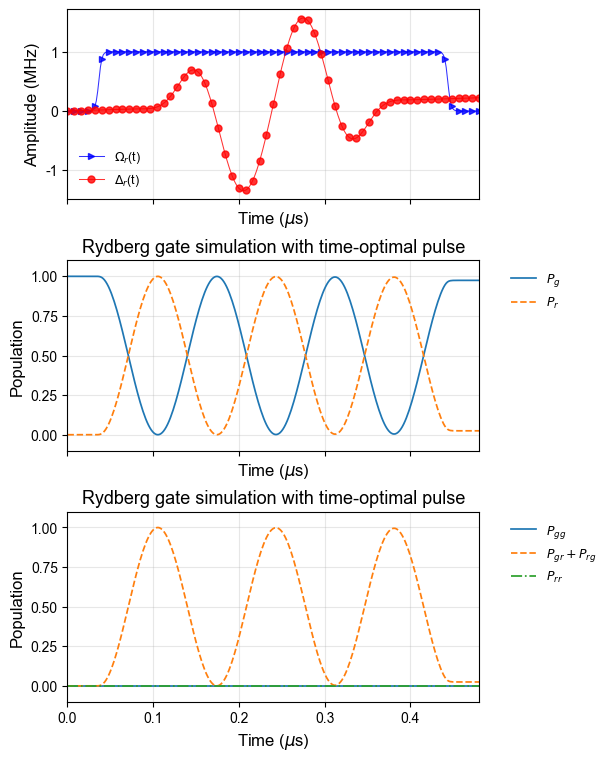

In [6]:
plotting_styles["Omega_r_pulse"]["markevery"] = 5
plotting_styles["Delta_r_pulse"]["markevery"] = 5
plt.rcParams.update(plt_config)

fig, axes = plt.subplots(3, 1, figsize=(6, 7.5), sharex=True, sharey=False, constrained_layout=True)
axes = axes.ravel()
# Plot the pulse shapes
pulse_dict = {
  'Omega_r': {'data': time_optimal_pulse_Omega_r, 'args': Omega_r_pulse_args, 
              'label': r'$\Omega_r$(t)', 'style': 'Omega_r_pulse', 'normalize_factor': amp_Omega_r},
  'Delta_r': {'data': time_optimal_pulse_Delta_r, 'args': Delta_r_pulse_args, 
              'label': r'$\Delta_r$(t)', 'style': 'Delta_r_pulse', 'normalize_factor': 1.0}
}

plot_pulse_shapes(
  ax = axes[0],
  tlist = tlist,
  pulse_dict = pulse_dict,
  title = None,
  xlabel = r"Time ($\mu$s)",
  ylabel = "Amplitude (MHz)",
  normalize_2pi = False,  # 使用每个脉冲自己的 normalize_factor
  ylim = None,
  grid_alpha = 0.3,
  # legend_config = legend_styles['compact'],
)
  
# Plot the population evolution
pop_list = [result.expect[0], result.expect[1]]
legend_list = [r"$P_g$", r"$P_r$"]

plot_population_evolution(
  ax = axes[1],
  tlist = tlist,
  pop_list = pop_list,
  legend_list = legend_list,
  plot_pulse = False,
  pulse_dict = {},
  title = r"Rydberg gate simulation with time-optimal pulse",
  xlabel = r"Time ($\mu$s)",
  ylabel = "Population",
  log_scale = False,
  xlim = None,
  ylim = None,
  grid_alpha = 0.3,
  show_legend = True,
  plotting_style_list = None,
)

# Plot the population evolution
pop_list = [result.expect[2], result.expect[3], result.expect[4]]
legend_list = [r"$P_{gg}$", r"$P_{gr} + P_{rg}$", r"$P_{rr}$"]

plot_population_evolution(
  ax = axes[2],
  tlist = tlist,
  pop_list = pop_list,
  legend_list = legend_list,
  plot_pulse = False,
  pulse_dict = {},
  title = r"Rydberg gate simulation with time-optimal pulse",
  xlabel = r"Time ($\mu$s)",
  ylabel = "Population",
  log_scale = False,
  xlim = None,
  ylim = None,
  grid_alpha = 0.3,
  show_legend = True,
  plotting_style_list = None,
)
